In [1]:
import rnn_model
import cv2
import numpy as np

# Tensorflow
import tensorflow as tf
print(tf.__version__)

from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers.convolutional import Conv3D



# Helper libraries
import random
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt

from jupyter_nb import seg_elevation

Using TensorFlow backend.



1.15.0


# Store bdd100k dataset in npz file. 
Note: Only need to run once

In [ ]:
def load_singe_video(seg_hash_name, test = False):
    """load 6 frames per video ending at 10th sec which has groud-truth results available."""
    index_list = range(975, 1001, 5) # time index before 10th second 
    # ground truth (gt) label
    gt_dir = "data/bdd100k/seg/labels/train_id20/resize"
    gt_label_file = os.path.join(gt_dir, seg_hash_name + "_train_id.png")
    gt = cv2.imread(gt_label_file, cv2.IMREAD_GRAYSCALE)[..., np.newaxis]

    # Pack into x (with 6 frames)
    x =[]
    # image list
    image_list = [seg_hash_name + "_" + str(idx) + ".png" for idx in index_list]

    # video image list
    video_image_dir = "data/bdd100k/video_images/train/resize"
    video_image_list = [os.path.join(video_image_dir, imgfile) for imgfile in image_list]
    
    # hrnet output
    hrnet_dir = "data/bdd100k/hrnet_output_id20/resize"
    hrnet_image_list = [os.path.join(hrnet_dir, imgfile) for imgfile in image_list]   
    
    x = []
    for i in range(len(video_image_list)):
        img_rbg =  cv2.imread(video_image_list[i])
        inf_seg = cv2.imread(hrnet_image_list[i], cv2.IMREAD_GRAYSCALE)[..., np.newaxis]
        x.append(np.concatenate((img_rbg, inf_seg), axis = 2))
    return np.array(x), gt

In [ ]:
def create_video_dataset(seg_hash_list, output_file):
    """Create npz file from bdd100k video dataset."""
    X = []
    Y = []
    for seg_hash in seg_hash_list:
        x, y = load_singe_video(seg_hash)
        X.append(x)
        Y.append(y)
    np.savez(output_file, X=X, Y=Y)

In [ ]:
seg_hash_list = rnn_model.read_seg_hash_list()
create_video_dataset(seg_hash_list, 'bdd_video_ds.npz')

# Load dataset

In [2]:
npzfile = np.load('bdd_video_ds.npz') # contain 435 examples
X, Y = npzfile['X'], npzfile['Y']
print('x shape: {}\ny shape: {}'.format(X.shape, Y.shape))

x shape: (435, 6, 360, 640, 4)
y shape: (435, 360, 640, 1)


Text(0.5, 1.0, 'ground-truth segmentation map')

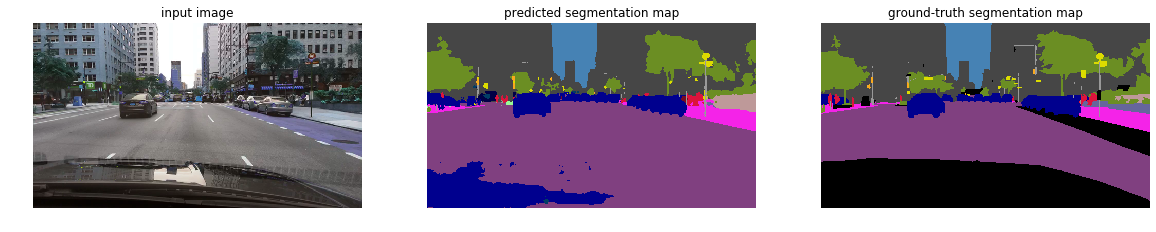

In [3]:
# plot a sample
plt.figure(figsize=(20, 8))
grid_spec = gridspec.GridSpec(1, 3, width_ratios=[6, 6, 6])
plt.subplot(grid_spec[0])
plt.imshow(X[0,5,:,:,:3])
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
plt.imshow(seg_elevation.label_to_color_image(X[0,5,:,:,3]))
plt.axis('off')
plt.title('predicted segmentation map')

plt.subplot(grid_spec[2])
plt.imshow(seg_elevation.label_to_color_image(Y[0].reshape(360, 640)))
plt.axis('off')
plt.title('ground-truth segmentation map')

In [4]:
def gen_bdd100k_data(X, Y, batch_size=1):
    """yields x with shape(batch_size, num_frames=6, height=360, width=640, channels=4)
    and y with shape(batch_size, num_frames, height, width, num_classes=20). 
    
    Note: y only have one-hot values at the last frame (i.e. 6th frame), other frames are 
    zero vectors (which does not contribute to loss function).
    """
    num_examples = X.shape[0]
    examples = list(range(num_examples))
    steps_per_epoch = num_examples // batch_size
    while True:
        random.shuffle(examples)
        for i in range(steps_per_epoch):
            batch_x=[]
            batch_y=[]
            for j in range(batch_size):
                idx = i*batch_size+j
                x = X[idx][:,:,:,3]
                #x[:,:,:,:3] = np.divide(x[:,:,:,:3], 255.)
                x = np.divide(x, 19.)[..., np.newaxis]              
                batch_x.append(x)
                y = np.zeros(X[idx].shape[:-1] + (20,))
                y[5] = to_categorical(Y[idx], num_classes=20)
                # y = np.zeros(X[idx].shape[:-1] + (1,))
                # y = Y[idx:idx+1]
                # print(y.shape)
                batch_y.append(y)
            yield np.array(batch_x), np.array(batch_y)

(1, 6, 360, 640, 1) (1, 6, 360, 640, 20)


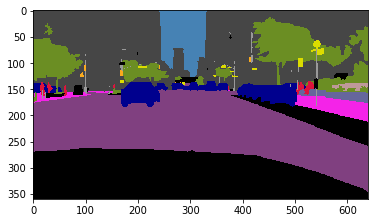

In [5]:
for x, y in gen_bdd100k_data(X[:1], Y[:1], batch_size=1):
    print(x.shape, y.shape)
    # plt.imshow(seg_elevation.label_to_color_image((x[0,5]*19).reshape(360, 640).astype(int)))
    # plt.imshow(seg_elevation.label_to_color_image(y[0, 0].reshape(360, 640).astype(int)))
    plt.imshow(seg_elevation.label_to_color_image(np.argmax(y, axis=4)[0, 5].reshape(360, 640).astype(int)))

    break

In [6]:
def build_conv_lstm_model(height, width, num_channels, num_classes):
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3,3),
                       input_shape=(None, height, width, num_channels),
                       padding='same', data_format='channels_last',
                       return_sequences=True))
    seq.add(BatchNormalization())   
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3,3),
                       padding='same',
                       return_sequences=True))
    seq.add(BatchNormalization()) 
    seq.add(ConvLSTM2D(filters=num_classes, kernel_size=(3, 3),                                                                                                                             
                       padding='same', return_sequences=True))  
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    seq.add(BatchNormalization())
    seq.add(Conv3D(filters=20, kernel_size=(3, 3, 3),
                   activation='sigmoid',
                   padding='same', data_format='channels_last'))    
#    run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    # opt = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, decay=0.01)
    seq.compile(
        optimizer='adam',
        # optimizer=opt,
        # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return seq

In [7]:
seq = build_conv_lstm_model(360, 640, 1, 20)
seq.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 360, 640, 40 59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 360, 640, 40 160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 360, 640, 40 115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 360, 640, 40 160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 360, 640, 20 43280     
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 360, 640, 40 86560     
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 360, 640, 40 160       
_____

In [8]:
seq.fit_generator(gen_bdd100k_data(X[:200], Y[:200], batch_size=1), steps_per_epoch=200, epochs=1, 
                  validation_data=gen_bdd100k_data(X[200:250], Y[200:250]), validation_steps=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





200/200 [==============================] - 1115s 6s/step - loss: 0.4415 - acc: 0.1943 - val_loss: 0.4202 - val_acc: 0.4956


(1, 6, 360, 640, 20)
[[14 13 13 ... 13 13 12]
 [10 13 13 ... 13 13 12]
 [13 13 13 ... 13 13 12]
 ...
 [13 13 13 ... 18 18 17]
 [13 13 13 ... 18 18 17]
 [10 10 14 ... 12 17 16]]


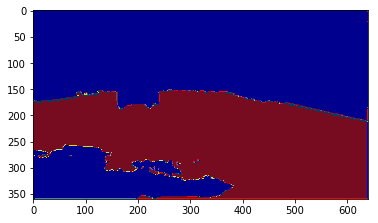

In [27]:
y = seq.predict(X[:1,:,:,:,3:])
print(y.shape)
y = np.argmax(y, axis=4)[0,0]
plt.imshow(seg_elevation.label_to_color_image(y))